# Baechi Full

In [1]:
import torch
import torchvision
from torchvision import models
import time
import networkx as nx
from torch import optim, nn
from importlib import reload
import numpy as np
import pickle

import GPUtil

import sys


## Copy of Inceptionv3, slightly modified for recording intermeridates
sys.path.append('/home/cshetty2/sct/pytorch')
import reformated_models.inception_modified as inception_modified

## Modified Alexnet, with a'factor' by which it can be made 'fat' 
import simple_model as sm

######## For profiler (some experiments. Not required) #################
from torch.profiler import profile, record_function, ProfilerActivity


## Placer libs of baechi
sys.path.append('/home/cshetty2/sct')
from placer.placer_lib import *

import matplotlib.pyplot as plt

######## For debug purposes ONLY ########
import ctypes, gc
import psutil, os

### From https://discuss.pytorch.org/t/how-pytorch-releases-variable-garbage/7277
def memReport():
    for obj in gc.get_objects():
        if torch.is_tensor(obj):
            print(type(obj), obj.size())
    
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)
#########################################

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from baechi_units import *

In [3]:
##### Change this settings in bbaechi_units.py file
# itype       = 'forward'  # help: forward/all -> Conside forward path only or both
# prof_rounds = 40      # help: 'rounds for profiler'
# prof_gpu_id = 3      # help: 'which gpu to place the profiler'
# batch_size  = '128'   # help: 'batch_size'
# gpu_num     = 3      # help: 'number of gpu to use'
# sch         = 'sct'  # help: 'sct/etf/topo'

# args = Args(itype, prof_rounds, prof_gpu_id, batch_size, gpu_num, sch)

In [4]:
print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------


#### ParallelModel

In [5]:
class _concatenateLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, *x):
        return torch.cat(x, 1)
    
class _squeezeLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.squeeze()

class _addLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x1, x2):
        return x1 + x2

In [6]:
class ParallelModel(nn.Module):

    def __init__(self, factor: int = 1) -> None:
        #super(ParallelModel, self).__init__()  # syntax in python2, works in python3
        # Explained here: https://stackoverflow.com/questions/61288224/why-not-super-init-model-self-in-pytorch
        super().__init__() # python 3 syntax
        
        self.factor = factor
        self.linear1N = 512*self.factor
        self.linear2N = 2048*self.factor
        self.linear3N = 1024*self.factor
        self.linear4N = 2*self.linear3N
        self.linear5N = 512*self.factor


        self.squeeze = _squeezeLayer()
        self.fc1 = nn.Linear(self.linear1N, self.linear2N)
        self.fc2a1 = nn.Linear(self.linear2N, self.linear3N)
        self.fc2a2 = nn.Linear(self.linear3N, self.linear3N)
        self.fc2b1 = nn.Linear(self.linear2N, self.linear3N)
        self.fc2b2 = nn.Linear(self.linear3N, self.linear3N)
        self.concatenate = _concatenateLayer()
        self.fc3 = nn.Linear(self.linear4N, self.linear5N)
        self.add1 = _addLayer()
        self.fc4 = nn.Linear(self.linear5N, self.linear5N)
        

    def forward(self, x):
        x = self.squeeze(x)
        x = self.fc1(x)
        xa1 = self.fc2a1(x)
        xa2 = self.fc2a2(xa1)
        xb1 = self.fc2b1(x)
        xb2 = self.fc2b2(xb1)
        y = self.concatenate(xa2,xb2)
        y = self.fc3(y)
        y = self.add1(y,xb2)
        y = self.fc4(y)
        return y

In [7]:
class ParallelModelSplit(nn.Module):

    def __init__(self, factor: int = 1) -> None:
        super().__init__() # python 3 syntax
        
        self.factor = factor
        self.linear1N = 512*self.factor
        self.linear2N = 2048*self.factor
        self.linear3N = 1024*self.factor
        self.linear4N = 2*self.linear3N
        self.linear5N = 512*self.factor


        self.squeeze = _squeezeLayer()
        
        self.fc1   = nn.Linear(self.linear1N, self.linear2N)
        torch.nn.init.constant_(self.fc1.weight, 1/512)
        torch.nn.init.zeros_(self.fc1.bias)
        
        self.fc2a1 = nn.Linear(self.linear2N, self.linear3N)
        torch.nn.init.constant_(self.fc2a1.weight, 1/512)
        torch.nn.init.zeros_(self.fc2a1.bias)
        
        self.fc2a2 = nn.Linear(self.linear3N, self.linear3N)
        torch.nn.init.constant_(self.fc2a2.weight, 1/512)
        torch.nn.init.zeros_(self.fc2a2.bias)
        
        self.fc2b1 = nn.Linear(self.linear2N, self.linear3N)
        torch.nn.init.constant_(self.fc2b1.weight, 1/512)
        torch.nn.init.zeros_(self.fc2b1.bias)
        
        self.fc2b2 = nn.Linear(self.linear3N, self.linear3N)
        torch.nn.init.constant_(self.fc2b2.weight, 1/512)
        torch.nn.init.zeros_(self.fc2b2.bias)
        
        self.concatenate = _concatenateLayer()
        
        self.fc3   = nn.Linear(self.linear4N, self.linear5N)
        torch.nn.init.constant_(self.fc3.weight, 1/512)
        torch.nn.init.zeros_(self.fc3.bias)
        
        
        self.fc4   = nn.Linear(self.linear5N, self.linear5N)
        torch.nn.init.constant_(self.fc4.weight, 1/512)
        torch.nn.init.zeros_(self.fc4.bias)
        

    def forward(self, x):
        x = self.squeeze(x)
        x = self.fc1(x)
        xa1 = self.fc2a1(x)
        xa2 = self.fc2a2(xa1)
        xb1 = self.fc2b1(x)
        xb2 = self.fc2b2(xb1)
        y = self.concatenate(xa2,xb2)
        y = self.fc3(y)
        y = self.fc4(y)
        return y

In [8]:
class ParallelModelThree(nn.Module):

    def __init__(self, factor: int = 1) -> None:
        super().__init__() # python 3 syntax
        
        self.factor = factor
        self.linear1N = 512*self.factor
        self.linear2N = 2048*self.factor
        self.linear3N = 1024*self.factor
        self.linear4N = 3*self.linear3N
        self.linear5N = 512*self.factor


        self.squeeze = _squeezeLayer()
        
        self.fc1   = nn.Linear(self.linear1N, self.linear2N)
        torch.nn.init.constant_(self.fc1.weight, 1/512)
        torch.nn.init.zeros_(self.fc1.bias)
        
        self.fc2a1 = nn.Linear(self.linear2N, self.linear3N)
        torch.nn.init.constant_(self.fc2a1.weight, 1/512)
        torch.nn.init.zeros_(self.fc2a1.bias)
        
        self.fc2a2 = nn.Linear(self.linear3N, self.linear3N)
        torch.nn.init.constant_(self.fc2a2.weight, 1/512)
        torch.nn.init.zeros_(self.fc2a2.bias)
        
        self.fc2b1 = nn.Linear(self.linear2N, self.linear3N)
        torch.nn.init.constant_(self.fc2b1.weight, 1/512)
        torch.nn.init.zeros_(self.fc2b1.bias)
        
        self.fc2b2 = nn.Linear(self.linear3N, self.linear3N)
        torch.nn.init.constant_(self.fc2b2.weight, 1/512)
        torch.nn.init.zeros_(self.fc2b2.bias)
        
        self.fc2c1 = nn.Linear(self.linear2N, self.linear3N)
        torch.nn.init.constant_(self.fc2c1.weight, 1/512)
        torch.nn.init.zeros_(self.fc2c1.bias)
        
        self.fc2c2 = nn.Linear(self.linear3N, self.linear3N)
        torch.nn.init.constant_(self.fc2c2.weight, 1/512)
        torch.nn.init.zeros_(self.fc2c2.bias)
        
        self.concatenate = _concatenateLayer()
        
        self.fc3   = nn.Linear(self.linear4N, self.linear5N)
        torch.nn.init.constant_(self.fc3.weight, 1/512)
        torch.nn.init.zeros_(self.fc3.bias)
        
        
        self.fc4   = nn.Linear(self.linear5N, self.linear5N)
        torch.nn.init.constant_(self.fc4.weight, 1/512)
        torch.nn.init.zeros_(self.fc4.bias)
        

    def forward(self, x):
        x = self.squeeze(x)
        x = self.fc1(x)
        xa1 = self.fc2a1(x)
        xa2 = self.fc2a2(xa1)
        xb1 = self.fc2b1(x)
        xb2 = self.fc2b2(xb1)
        xc1 = self.fc2c1(x)
        xc2 = self.fc2c2(xc1)
        y = self.concatenate(xa2,xb2,xc2)
        y = self.fc3(y)
        y1 = self.fc4(y)
        return y1

In [9]:
class TallParallelModel(nn.Module):

    def __init__(self, factor: int = 1) -> None:
        #super(TwoLayerLinearModel, self).__init__()  # syntax in python2, works in python3
        # Explained here: https://stackoverflow.com/questions/61288224/why-not-super-init-model-self-in-pytorch
        super().__init__() # python 3 syntax
        
        self.factor = factor
        self.linear1N = 512*self.factor
        self.linear2N = 2048*self.factor
        self.linear3N = 1024*self.factor
        self.linear4N = 2*self.linear3N
        self.linear5N = 512*self.factor

        self.squeeze = _squeezeLayer()
        self.fc1 = nn.Linear(self.linear1N, self.linear2N)
        self.fc2a = nn.Linear(self.linear2N, self.linear3N)
        self.fc2b = nn.Linear(self.linear2N, self.linear3N)
        self.concatenate = _concatenateLayer()
        self.fc3 = nn.Linear(self.linear4N, self.linear5N)
        self.fc4 = nn.Linear(self.linear5N, self.linear5N)
        self.fc5 = nn.Linear(self.linear5N, self.linear5N)
        self.fc6 = nn.Linear(self.linear5N, self.linear5N)
        self.fc7 = nn.Linear(self.linear5N, self.linear5N)
        self.fc8 = nn.Linear(self.linear5N, self.linear5N)
        self.fc9 = nn.Linear(self.linear5N, self.linear5N)
        self.fc10 = nn.Linear(self.linear5N, self.linear5N)
        self.fc11 = nn.Linear(self.linear5N, self.linear5N)
        self.fc12 = nn.Linear(self.linear5N, self.linear5N)
        self.fc13 = nn.Linear(self.linear5N, self.linear5N)
        self.fc14 = nn.Linear(self.linear5N, self.linear5N)
        self.fc15 = nn.Linear(self.linear5N, self.linear5N)
        self.fc16 = nn.Linear(self.linear5N, self.linear5N)
        self.fc17 = nn.Linear(self.linear5N, self.linear5N)
        self.fc18 = nn.Linear(self.linear5N, self.linear5N)
        self.fc19 = nn.Linear(self.linear5N, self.linear5N)
        self.fc20 = nn.Linear(self.linear5N, self.linear5N)
        self.fc21 = nn.Linear(self.linear5N, self.linear5N)
        self.fc22 = nn.Linear(self.linear5N, self.linear5N)
        self.fc23 = nn.Linear(self.linear5N, self.linear5N)
        self.fc24 = nn.Linear(self.linear5N, self.linear5N)
        self.fc25 = nn.Linear(self.linear5N, self.linear5N)
        self.fc26 = nn.Linear(self.linear5N, self.linear5N)
        self.fc27 = nn.Linear(self.linear5N, self.linear5N)
        self.fc28 = nn.Linear(self.linear5N, self.linear5N)
        self.fc29 = nn.Linear(self.linear5N, self.linear5N)
          

    def forward(self, x):
        x = self.squeeze(x)
        x = self.fc1(x)
        xb = self.fc2b(x)
        xa = self.fc2a(x)
        y = self.concatenate(xa,xb)
        y = self.fc3(y)
        y = self.fc4(y)
        y = self.fc5(y)
        y = self.fc6(y)
        y = self.fc7(y)
        y = self.fc8(y)
        y = self.fc9(y)
        y = self.fc10(y)
        y = self.fc11(y)
        y = self.fc12(y)
        y = self.fc13(y)
        y = self.fc14(y)
        y = self.fc15(y)
        y = self.fc16(y)
        y = self.fc17(y)
        y = self.fc18(y)
        y = self.fc19(y)
        y = self.fc20(y)
        y = self.fc21(y)
        y = self.fc22(y)
        y = self.fc23(y)
        y = self.fc24(y)
        y = self.fc25(y)
        y = self.fc26(y)
        y = self.fc27(y)
        y = self.fc28(y)
        y = self.fc29(y)
        
        return y

# Settings of the experiment

In [10]:
model_name = "ParallelModelThree"
Nrun = 11 
fct = 6
run_type = "forward" 
repetable = 0

In [11]:
if model_name == "toyToyModel":
    model = sm.toyToyModel(factor=fct)
    inp_size_single = (3, 299, 299)
    opt_size = 1000

if model_name == "linearModel":
    model = sm.linearModel(factor=fct)
    inp_size_single = (1, 10000)
    opt_size = 1000

if model_name == "parallelToyModel":
    model = sm.parallelToyModel(factor=fct)
    inp_size_single = (3, 299, 299)
    opt_size = 1000

if model_name == "toyModel":
    model = sm.toyModel(factor=fct)
    inp_size_single = (3, 299, 299)
    opt_size = 1000

if model_name == "inception_v3":
    model = inception_modified.inception_v3(pretrained=True)
    inp_size_single = (3, 299, 299)
    opt_size = 1000

if model_name == "TallParallelModel":
    factor = fct
    inp_size_single = (1, 512*factor)
    model = TallParallelModel(factor)
    opt_size = 1000

    
if model_name == "ParallelModel":
    factor = fct
    inp_size_single = (1, 512*factor)
    model = ParallelModel(factor)
    opt_size = 512*fct
    
if model_name == "ParallelModelSplit":
    factor = fct
    inp_size_single = (1, 512*factor)
    model = ParallelModelSplit(factor)
    opt_size = 512*fct
    repetable = 1
    
if model_name == "ParallelModelThree":
    factor = fct
    inp_size_single = (1, 512*factor)
    model = ParallelModelThree(factor)
    opt_size = 512*fct
    repetable = 1

In [12]:
print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------


## Single GPU Run

In [13]:
single_run_gpu = 3
inp_size = (int(args.batch_size),) + inp_size_single
model = model.to(single_run_gpu)

In [14]:
if run_type == "forward":
    times = []
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
        for _ in range(Nrun):
            torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2)
            if repetable == 1:
                inp   = torch.ones(inp_size)
            else:
                inp   = torch.rand(inp_size)
            start = time.time()
            inp = inp.to(single_run_gpu)
            output = model(inp)
            torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2)
            end = time.time()
            #print_mem(args.prof_gpu_id)
            times.append(1000*(end-start))
    prof.export_chrome_trace("trace_singlegpu.json")
    single_gpu_time = np.mean(times[10:])
    print("Mean time taken:", single_gpu_time)
    print()


Mean time taken: 8.058309555053711



In [15]:
if run_type == "training":

    optimizer = optim.SGD(model.parameters(), lr = 0.0001); 
    criterion = nn.MSELoss()
    dataset = torchvision.datasets.FakeData(
        size= args.prof_rounds * int(args.batch_size),
        image_size=inp_size_single,
        num_classes=opt_size,
        transform=torchvision.transforms.ToTensor())
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=int(args.batch_size))
    result = []


    times = []
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
        for batch_idx, (inp, oup) in enumerate(data_loader):
            torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
            labels = torch.randn(opt_size).to(single_run_gpu)
            start = time.time()
            inp = inp.to(single_run_gpu); 
            optimizer.zero_grad()
            output = model(inp)
            #torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
            ######################### loss compute ################################################
            loss = criterion(output, labels )
            ##################################################################################
            loss.backward(loss)
            optimizer.step()
            torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
            end = time.time()
            times.append(1000*(end-start))
    prof.export_chrome_trace("trace_singlegpu.json")
    single_gpu_time = np.mean(times[10:])
    print("Mean time taken:", single_gpu_time)
    print()


In [16]:
print(output)

tensor([[373248., 373248., 373248.,  ..., 373248., 373248., 373248.],
        [373248., 373248., 373248.,  ..., 373248., 373248., 373248.],
        [373248., 373248., 373248.,  ..., 373248., 373248., 373248.],
        ...,
        [373248., 373248., 373248.,  ..., 373248., 373248., 373248.],
        [373248., 373248., 373248.,  ..., 373248., 373248., 373248.],
        [373248., 373248., 373248.,  ..., 373248., 373248., 373248.]],
       device='cuda:3', grad_fn=<AddmmBackward>)


In [17]:

print_gpu_memory()
del model
del inp
del output
try:
    del labels
    del optimizer
    del loss
except: pass
gc.collect()
torch.cuda.empty_cache()
print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 1.65950775 GB
Cached:    1.68359375 GB
-----------
GPU: 0
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------


## Baechi Run

In [18]:
if model_name == "toyToyModel":
    model = sm.toyToyModel(factor=fct)
    inp_size_single = (3, 299, 299)
    opt_size = 1000

if model_name == "linearModel":
    model = sm.linearModel(factor=fct)
    inp_size_single = (1, 10000)
    opt_size = 1000

if model_name == "parallelToyModel":
    model = sm.parallelToyModel(factor=fct)
    inp_size_single = (3, 299, 299)
    opt_size = 1000

if model_name == "toyModel":
    model = sm.toyModel(factor=fct)
    inp_size_single = (3, 299, 299)
    opt_size = 1000

if model_name == "inception_v3":
    model = inception_modified.inception_v3(pretrained=True)
    inp_size_single = (3, 299, 299)
    opt_size = 1000

if model_name == "TallParallelModel":
    factor = fct
    inp_size_single = (1, 512*factor)
    model = TallParallelModel(factor)
    opt_size = 1000

    
if model_name == "ParallelModel":
    factor = fct
    inp_size_single = (1, 512*factor)
    model = ParallelModel(factor)
    opt_size = 512*fct
    
if model_name == "ParallelModelSplit":
    factor = fct
    inp_size_single = (1, 512*factor)
    model = ParallelModelSplit(factor)
    opt_size = 512*fct
    
if model_name == "ParallelModelThree":
    factor = fct
    inp_size_single = (1, 512*factor)
    model = ParallelModelThree(factor)
    opt_size = 512*fct

In [19]:
inp_size = inp_size_single

In [20]:
return_graph, tester = build_graph(model, args.prof_gpu_id, args.prof_rounds, inp_size = inp_size)
available_devices = range(args.gpu_num)
available_device_list = {k:device_list[k] for k in available_devices}
DEVICE_GRAPH_MULTIPLE = create_device_graph(available_device_list)

Profiling started ********************
--> Module name:  _squeezeLayer()
--> Module name:  Linear(in_features=3072, out_features=12288, bias=True)
--> Module name:  Linear(in_features=12288, out_features=6144, bias=True)
--> Module name:  Linear(in_features=6144, out_features=6144, bias=True)
--> Module name:  Linear(in_features=12288, out_features=6144, bias=True)
--> Module name:  Linear(in_features=6144, out_features=6144, bias=True)
--> Module name:  Linear(in_features=12288, out_features=6144, bias=True)
--> Module name:  Linear(in_features=6144, out_features=6144, bias=True)
--> Module name:  _concatenateLayer()
--> Module name:  Linear(in_features=18432, out_features=3072, bias=True)
--> Module name:  Linear(in_features=3072, out_features=3072, bias=True)


/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32, 3072])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/cshetty2/anaconda3/envs/baechi/lib/python3.6/site-packages/torch/cuda/memory.py:263: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda

make_dot started ********************
Dealing with this variable: <AddmmBackward object at 0x7f4c40541dd8>
Dealing with this variable: <AddmmBackward object at 0x7f4c4054c128>
Dealing with this variable: <CatBackward object at 0x7f4be6164198>
Dealing with this variable: <AddmmBackward object at 0x7f4bcc784e48>
Dealing with this variable: <AddmmBackward object at 0x7f4bcc7847f0>
Dealing with this variable: <AddmmBackward object at 0x7f4bcc799080>
Dealing with this variable: <SqueezeBackward0 object at 0x7f4bcc799128>
Dealing with this variable: <TBackward object at 0x7f4bcc799198>
Dealing with this variable: <TBackward object at 0x7f4bcc7992e8>
Dealing with this variable: <TBackward object at 0x7f4bcc784ac8>
Dealing with this variable: <AddmmBackward object at 0x7f4bcc784dd8>
Dealing with this variable: <AddmmBackward object at 0x7f4bcc784b38>
Dealing with this variable: <AddmmBackward object at 0x7f4bcc799080>
Dealing with this variable: <TBackward object at 0x7f4bcc7990f0>
Dealing wit

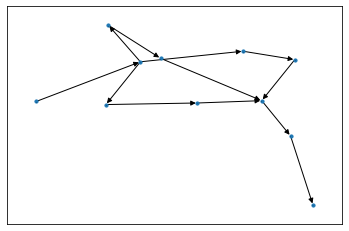

In [21]:
nx.draw_networkx(return_graph, node_size=10, font_size=1)

In [22]:
with torch.no_grad():
    placed_op_graph = m_sct(return_graph, DEVICE_GRAPH_MULTIPLE)
copy_p(return_graph, tester)



2021-11-03 11:19:57,668 - m_sct_v1:157 - INFO - Start LP solver.


Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization problem)
  Constraints            : 78              
  Cones                  : 0               
  Scalar variables       : 24              
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 5
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : LO (linear optimization 

2021-11-03 11:19:57,727 - m_sct_v1:162 - INFO - LP solver finished. Relaxed makespan soultion: 5.182024
2021-11-03 11:19:57,728 - m_sct_v1:140 - INFO - Favorite child round threshold: 0.5
2021-11-03 11:19:57,730 - m_sct:143 - INFO - # favorite child: 8
2021-11-03 11:19:57,730 - m_sct:144 - INFO - # favorite child changes: 0
2021-11-03 11:19:57,763 - m_sct:172 - INFO - SCT estimated runtime: 0.000006


Available mem:  8000000000
Op memory: 393216.0
Available mem:  8000000000
Op memory: 393216.0
Available mem:  8000000000
Op memory: 393216.0
0
Available mem:  8000000000
Op memory: 393216.0
Checking placement***************************************
Available mem:  8000000000
Op memory: 393216.0
True
Available mem:  8000000000
Op memory: 393216.0
********************
Device id:  0
Memory limit:  8000000000
Availale memory:  8000000000
_squeezeLayer()  :  0
Available mem:  7999606784.0
Op memory: 152616960.0
Available mem:  8000000000
Op memory: 152616960.0
Available mem:  8000000000
Op memory: 152616960.0
Available mem:  7999606784.0
Op memory: 152616960.0
0
Available mem:  7999606784.0
Op memory: 152616960.0
Checking placement***************************************
Available mem:  7999606784.0
Op memory: 152616960.0
True
Available mem:  7999606784.0
Op memory: 152616960.0
********************
Device id:  0
Memory limit:  8000000000
Availale memory:  7999606784.0
Linear(in_features=3072,

In [23]:
first_gpu = -1
for node_id in tester.sub_module_nodes:
    print(tester.sub_module_nodes[node_id].module)
    curr_gpu_id = tester.sub_module_nodes[node_id].p
    print(curr_gpu_id)
    if first_gpu < 0:
        first_gpu = curr_gpu_id
    print()
final_gpu = curr_gpu_id

_squeezeLayer()
0

Linear(in_features=3072, out_features=12288, bias=True)
0

Linear(in_features=12288, out_features=6144, bias=True)
1

Linear(in_features=6144, out_features=6144, bias=True)
1

Linear(in_features=12288, out_features=6144, bias=True)
0

Linear(in_features=6144, out_features=6144, bias=True)
0

Linear(in_features=12288, out_features=6144, bias=True)
0

Linear(in_features=6144, out_features=6144, bias=True)
0

_concatenateLayer()
0

Linear(in_features=18432, out_features=3072, bias=True)
0

Linear(in_features=3072, out_features=3072, bias=True)
0



In [24]:
Assign(tester)

Module:               _squeezeLayer()
GPU:                  0
Memory change:        0
Layer size:           0
Net memory occupied:  0
**************************************************
Module:               Linear(in_features=3072, out_features=12288, bias=True)
GPU:                  0
Memory change:        302088192
Layer size:           151044096
Net memory occupied:  302088192
**************************************************
Module:               Linear(in_features=12288, out_features=6144, bias=True)
GPU:                  1
Memory change:        604028928
Layer size:           302014464
Net memory occupied:  604028928
**************************************************
Module:               Linear(in_features=6144, out_features=6144, bias=True)
GPU:                  1
Memory change:        302039040
Layer size:           151019520
Net memory occupied:  906067968
**************************************************
Module:               Linear(in_features=12288, out_features=6144, bi

In [25]:
inp_size = (int(args.batch_size),) + inp_size_single
inp_size

(32, 1, 3072)

In [26]:
if run_type == "forward":
    times = []
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof1:
        for _ in range(Nrun):
            torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2)
            if repetable == 1:
                inp   = torch.ones(inp_size)
            else:
                inp   = torch.rand(inp_size)
            start = time.time()
            #with torch.no_grad():
            inp = inp.to(first_gpu)  ### Code works even without this
                                            ### However, not having this gives a time penalty
                                            ### of ~6%
            output = tester.model(inp)
            torch.cuda.synchronize(0); torch.cuda.synchronize(1); torch.cuda.synchronize(2)
            end = time.time()
            #print_mem(args.prof_gpu_id)
            times.append(1000*(end-start))
    prof1.export_chrome_trace("trace_baechi.json")

    baechi_time = np.mean(times[10:])
    print("Mean time taken:", baechi_time)
    print()

Mean time taken: 6.62684440612793



In [27]:
if run_type == "training":

    optimizer = optim.SGD(model.parameters(), lr = 0.0001); 
    criterion = nn.MSELoss()
    dataset = torchvision.datasets.FakeData(
        size= args.prof_rounds * int(args.batch_size),
        image_size=inp_size_single,
        num_classes=opt_size,
        transform=torchvision.transforms.ToTensor())
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=int(args.batch_size))


    times = []
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof1:
        for batch_idx, (inp, oup) in enumerate(data_loader):
            torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
            labels = torch.randn(opt_size).to(final_gpu)
            start = time.time()
            inp = inp.to(first_gpu); 
            optimizer.zero_grad()
            output = model(inp)
            #torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
            ######################### loss compute ################################################
            loss = criterion(output, labels )
            ##################################################################################
            loss.backward(loss)
            optimizer.step()
            torch.cuda.synchronize(0);torch.cuda.synchronize(1);torch.cuda.synchronize(2);torch.cuda.synchronize(3)
            end = time.time()
            times.append(1000*(end-start))
    prof1.export_chrome_trace("trace_baechi.json")

    baechi_time = np.mean(times[10:])
    print("Mean time taken:", baechi_time)
    print()


In [28]:
print(output)

tensor([[373248., 373248., 373248.,  ..., 373248., 373248., 373248.],
        [373248., 373248., 373248.,  ..., 373248., 373248., 373248.],
        [373248., 373248., 373248.,  ..., 373248., 373248., 373248.],
        ...,
        [373248., 373248., 373248.,  ..., 373248., 373248., 373248.],
        [373248., 373248., 373248.,  ..., 373248., 373248., 373248.],
        [373248., 373248., 373248.,  ..., 373248., 373248., 373248.]],
       device='cuda:0', grad_fn=<AddmmBackward>)


In [29]:
print_gpu_memory()
del model
del inp
del output
try:
    del labels
    del optimizer
    del loss
except: pass
gc.collect()
print_gpu_memory()

GPU: 0
Memory Usage:
Allocated: 2.46748352 GB
Cached:    2.49023438 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.84603882 GB
Cached:    0.8671875 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    3.859375 GB
-----------
GPU: 0
Memory Usage:
Allocated: 2.46125793 GB
Cached:    2.49023438 GB
-----------
GPU: 1
Memory Usage:
Allocated: 0.84384155 GB
Cached:    0.8671875 GB
-----------
GPU: 2
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
-----------
GPU: 3
Memory Usage:
Allocated: 0.0 GB
Cached:    3.859375 GB
-----------


In [30]:
print("Run Type:", run_type)
print("Single GPU Mean execution time (ms): ", single_gpu_time)
print("Baechi Execution Time (ms): ",baechi_time)

Run Type: forward
Single GPU Mean execution time (ms):  8.058309555053711
Baechi Execution Time (ms):  6.62684440612793
